# Importing Basic Packages

In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense ,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Loading the Data

In [6]:
train_dir= '/content/drive/MyDrive/Work/Datasets/Emotion/test'
test_dir= '/content/drive/MyDrive/Work/Datasets/Emotion/train'

In [7]:
train_data = []
train_label = []

balance_exp = 3000 
batch_size  = 32
num_expressions = 6
labels = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

print ("\nTraining Data Summary\n")
for each_emotion in os.listdir(train_dir):
    if each_emotion!= 'disgusted':
        img_count = 0
        emotion_dir = os.path.join(train_dir,each_emotion)
        
        for each_img in os.listdir(emotion_dir):
            if img_count<balance_exp:
                img = cv2.imread(os.path.join(emotion_dir,each_img),0)
                train_data.append(img)
                train_label.append(each_emotion)
                img_count+=1
        print ("Emotion: {}, Image Count: {}".format(each_emotion,img_count))

test_data = []
test_label = []

print ("\nTesting Data Summary\n")
for each_emotion in os.listdir(test_dir):
    if each_emotion!= 'disgusted':
        emotion_dir = os.path.join(test_dir,each_emotion)
        img_count = 0
        for each_img in os.listdir(emotion_dir):
            img = cv2.imread(os.path.join(emotion_dir,each_img),0)
            if each_emotion!= 'disgusted':
                test_data.append(img)
                test_label.append(each_emotion) 
                img_count+=1
        print ("Emotion: {}, Image Count: {}".format(each_emotion,img_count))


Training Data Summary

Emotion: sad, Image Count: 1247
Emotion: fearful, Image Count: 1024
Emotion: angry, Image Count: 958
Emotion: happy, Image Count: 1774
Emotion: surprised, Image Count: 831
Emotion: neutral, Image Count: 1233

Testing Data Summary

Emotion: angry, Image Count: 3995
Emotion: fearful, Image Count: 4107
Emotion: happy, Image Count: 7215
Emotion: surprised, Image Count: 3171
Emotion: neutral, Image Count: 4965
Emotion: sad, Image Count: 4830


# Creating the Model

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
train_label = le.fit_transform(train_label)
#test_label = le.fit_transform(test_label)

train_label = to_categorical(train_label)
#test_label = to_categorical(test_label)

In [9]:
train_datagen = ImageDataGenerator(  width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     horizontal_flip = True,
                                     rescale = 1./255,
                                     zoom_range = 0.2                                 
                                        )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
from sklearn.model_selection import train_test_split

(trainX, valX, trainY, valY) = train_test_split(train_data, train_label, test_size=0.20, random_state=42)

In [11]:
trainX = np.asarray(trainX)
trainX = np.expand_dims(trainX, axis=3)

valX = np.asarray(valX)
valX = np.expand_dims(valX, axis=3)

#test_data = np.asarray(test_data)

print (trainX.shape)
print (valX.shape)

(5653, 48, 48, 1)
(1414, 48, 48, 1)


In [12]:
test_data = np.asarray(test_data)
print (test_data.shape)
test_data = np.expand_dims(test_data, axis=3)
print (test_data.shape)

(28283, 48, 48)
(28283, 48, 48, 1)


In [13]:
train_generator = train_datagen.flow(trainX, np.asarray(trainY), batch_size=batch_size)
val_generator = train_datagen.flow(valX, np.asarray(valY), batch_size=batch_size)

In [14]:
def model_definition(num_expressions):
    exp_model = Sequential()
    exp_model.add(Conv2D(input_shape = (48,48,1), filters=64, kernel_size=(3,3), activation='relu', data_format='channels_last',padding='same'))
    exp_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', data_format='channels_last',padding='same'))
    #exp_model.add(BatchNormalization())
    exp_model.add(MaxPool2D())
    #exp_model.add(Dropout(0.5))

    exp_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', data_format='channels_last',padding='same'))
    #exp_model.add(BatchNormalization())

    exp_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', data_format='channels_last',padding='same'))
    '''
    exp_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', data_format='channels_last',padding='same'))
    exp_model.add(BatchNormalization())
    exp_model.add(MaxPool2D())
    exp_model.add(Dropout(0.5))
    '''
    exp_model.add(MaxPool2D())

    exp_model.add(Flatten())
    
    # Fully connected layer 1st layer
    exp_model.add(Dense(512, activation="relu"))
    exp_model.add(BatchNormalization())
    #exp_model.add(Activation('relu'))
    # Fully connected layer 2nd layer
    exp_model.add(Dense(256, activation='relu'))
    exp_model.add(BatchNormalization())
    #exp_model.add(Activation('relu'))

    exp_model.add(Dense(128, activation='relu'))
    exp_model.add(Dense(num_expressions, activation="softmax"))

    return exp_model


In [15]:
exp_model = model_definition(num_expressions)

In [16]:
print ("Model Summary is \n")
print (exp_model.summary())

Model Summary is 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                 

In [17]:
opt = Adam(learning_rate=0.0005)
exp_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#define the early stopping
es_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [18]:
history = exp_model.fit(train_generator,
    batch_size = batch_size,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 1000, #add the validation set to evaluate the performance in each run
    validation_data = val_generator,
    callbacks = [es_callback]                            
) 

Epoch 1/1000
177/177 [==============================] - 20s 57ms/step - loss: 1.8224 - accuracy: 0.2468 - val_loss: 1.7753 - val_accuracy: 0.2489
Epoch 2/1000
177/177 [==============================] - 9s 52ms/step - loss: 1.7571 - accuracy: 0.2738 - val_loss: 2.3436 - val_accuracy: 0.2298
Epoch 3/1000
177/177 [==============================] - 9s 51ms/step - loss: 1.7213 - accuracy: 0.2899 - val_loss: 2.2115 - val_accuracy: 0.1372
Epoch 4/1000
177/177 [==============================] - 9s 52ms/step - loss: 1.6795 - accuracy: 0.3101 - val_loss: 1.7912 - val_accuracy: 0.2751
Epoch 5/1000
177/177 [==============================] - 9s 52ms/step - loss: 1.6685 - accuracy: 0.3204 - val_loss: 1.6862 - val_accuracy: 0.3204
Epoch 6/1000
177/177 [==============================] - 9s 52ms/step - loss: 1.6292 - accuracy: 0.3425 - val_loss: 1.8873 - val_accuracy: 0.2207
Epoch 7/1000
177/177 [==============================] - 9s 52ms/step - loss: 1.5888 - accuracy: 0.3692 - val_loss: 1.6284 - val_a

Text(0.5, 1.0, 'Training and Validation Loss')

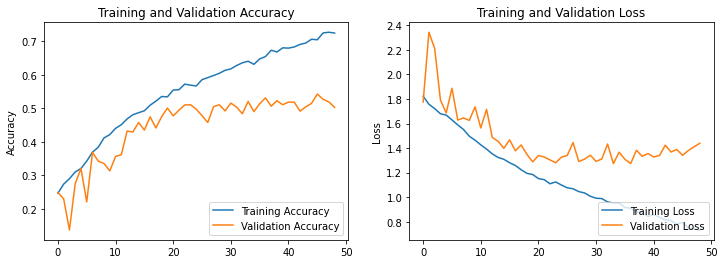

In [19]:
acc = history.history['accuracy'] # get history report of the model
val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(acc, label='Training Accuracy') #plot accuracy curve for each train run
ax[0].plot(val_acc, label='Validation Accuracy') #plot accuracy curve for each validation run

ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy') #label name for y axis
ax[0].set_title('Training and Validation Accuracy') #set title for the plot


ax[1].plot(loss, label='Training Loss') #plot accuracy curve for each train run
ax[1].plot(val_loss, label='Validation Loss') #plot accuracy curve for each validation run

ax[1].legend(loc='lower right')
ax[1].set_ylabel('Loss') #label name for y axis
ax[1].set_title('Training and Validation Loss') #set title for the plot

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

le = LabelEncoder()
test_labels = le.fit_transform(test_label)
#test_label = le.fit_transform(test_label)

test_labels = to_categorical(test_labels)

test_generator = test_datagen.flow(test_data, np.asarray(test_labels),batch_size=batch_size)

884/884 [==============================] - 14s 16ms/step - loss: 1.3776 - accuracy: 0.5384
Test Prediction done!

test_predictions:	 [0 2 2 ... 5 2 0]
test_label:	 <class 'numpy.ndarray'>
Classification Report
              precision    recall  f1-score   support

           0       0.15      0.12      0.13      3995
           1       0.14      0.20      0.17      4107
           2       0.26      0.25      0.26      7215
           3       0.18      0.18      0.18      4965
           4       0.18      0.13      0.15      4830
           5       0.11      0.12      0.11      3171

    accuracy                           0.18     28283
   macro avg       0.17      0.17      0.17     28283
weighted avg       0.18      0.18      0.18     28283

DONE

Confusion Matrix


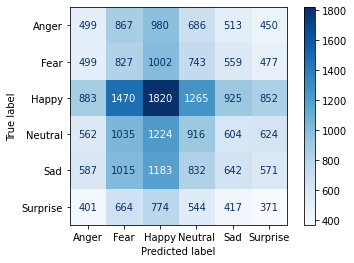

In [24]:
exp_model.evaluate(test_generator)
exp_model.save('/content/drive/MyDrive/Work/Datasets/Emotion/exp_det.h5')

test_predictions = exp_model.predict(test_generator)
print ("Test Prediction done!\n")
test_predictions = np.argmax(test_predictions,axis=1)

print ("test_predictions:\t", test_predictions)
#test_label = label_dict.index(test_label)

'''
for each_label in test_label:
    print ("each_label:\t", each_label)
    test_label_index = test_label.index(each_label)    
    if each_label == 'angry':
        label = 0
    elif each_label == 'fearful':
        label = 1
    elif each_label == 'happy':
        label = 2  
    elif each_label == 'neutral':
        label = 3         
    elif each_label == 'sad':
        label = 4 
    elif each_label == 'surprised':
        label = 5         
        test_label[test_label_index] = label
for a in list(test_labels):
    print (a)
''' 
    
print ("test_label:\t", type(test_labels))
test_labels = list(test_labels)
test_labels = np.argmax(test_labels, axis=1)
cm = confusion_matrix(test_labels, test_predictions)
#print (cm)
print('Classification Report')


print(classification_report(test_labels, test_predictions))
print ('DONE') 
print('\nConfusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()